In [60]:
import pandas as pd
from simpledbf import Dbf5
import seaborn as sns
from osgeo import gdal, ogr, osr
import numpy as np

## 1) Import wealth and geographical data

The objective is to import two dataset : the first one corresponds to the surveys' results, in particular the wealth index, and the second one corresponds to the geographical coordinates linked to these surveys.

In [2]:
wealth_file = './data/wealth_surveys/DHS/Rwanda_2010/RWHR61FL.DTA'
geo_file = './data/wealth_surveys/DHS/Rwanda_2010/RWGE61FL.dbf'

The first file (RWHR61FL.DTA) contains the surveys' results. Two columns are of particular interest to us : HV001 is an identifier that links to geographic data and HV271 contains an index of the region's wealth.

In [3]:
df_wealth = pd.read_stata(wealth_file)
df_wealth.head()

,hhid,hv000,hv001,hv002,hv003,hv004,hv005,hv006,hv007,hv008,...,sh175_7,sh175_8,sh176_1,sh176_2,sh176_3,sh176_4,sh176_5,sh176_6,sh176_7,sh176_8
0,12115,RW6,121,15,2,121,737365,2,2011,1334,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12119,RW6,121,19,1,121,737365,3,2011,1335,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12121,RW6,121,21,2,121,737365,2,2011,1334,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12116,RW6,121,16,2,121,737365,2,2011,1334,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,121 3,RW6,121,3,2,121,737365,2,2011,1334,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
result_wealth = df_wealth.groupby('hv001')['hv271'].median().reset_index()
result_wealth['hv271'] /= 100000.
result_wealth.head()

,hv001,hv271
0,1,-0.531405
1,2,-0.409830
2,3,-0.478115
3,4,-0.435960
4,5,-0.449480


The second file contains the surveys' geographical coordinates. We are particularly interested in the DHSCLUST column which links to the clusters in the previous file as well as the LATNUM and LONGNUM columns which will gives us the coordinates of the region. We'll then be able to have access to the light intensity of these geographical areas as well as the satellite images.

In [5]:
dbf = Dbf5(geo_file)
df_geo = dbf.to_dataframe()

In [6]:
result_geo = df_geo[['DHSCLUST', 'LATNUM', 'LONGNUM']]
result_geo['DHSCLUST'] = result_geo['DHSCLUST'].astype(int)
result_geo.head()

/home/ridouane/anaconda3/envs/Predict-poverty/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,DHSCLUST,LATNUM,LONGNUM
0,1,-2.532818,29.684726
1,2,-1.833858,30.310689
2,3,-1.888155,29.478298
3,4,-2.366763,30.521692
4,5,-2.171266,30.018541


## 2) Merge wealth and geographical data

We then combine the two previous tables to have the wealth and coordinates of each region.

In [7]:
wealth_geo_merge = pd.merge(result_wealth, result_geo, how='inner', left_on='hv001', right_on='DHSCLUST')[['DHSCLUST', 'LATNUM', 'LONGNUM', 'hv271']]
wealth_geo_merge = wealth_geo_merge.rename(columns={'DHSCLUST': 'cluster', 'LATNUM': 'latitude', 'LONGNUM': 'longitude', 'hv271': 'wealth_index'})
wealth_geo_merge.head()

,cluster,latitude,longitude,wealth_index
0,1,-2.532818,29.684726,-0.531405
1,2,-1.833858,30.310689,-0.409830
2,3,-1.888155,29.478298,-0.478115
3,4,-2.366763,30.521692,-0.435960
4,5,-2.171266,30.018541,-0.449480


In [8]:
wealth_geo_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 492 entries, 0 to 491
Data columns (total 4 columns):
cluster         492 non-null int64
latitude        492 non-null float64
longitude       492 non-null float64
wealth_index    492 non-null float64
dtypes: float64(3), int64(1)
memory usage: 19.2 KB


In [68]:
n_clust = wealth_geo_merge['cluster'].max()
print(n_clust)

492


In [11]:
to_drop = []
for index, row in wealth_geo_merge.iterrows() :
    sample = row['longitude'], row['latitude']
    if sample == (0., 0.):
        to_drop.append(index)
wealth_geo_merge = wealth_geo_merge.drop(to_drop)

[]

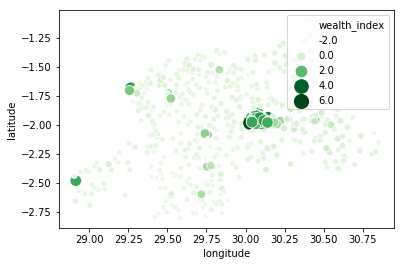

In [49]:
sns.scatterplot(x='longitude', y='latitude', 
                hue='wealth_index', palette='Greens', 
                size='wealth_index', sizes=(10, 200), 
                data=wealth_geo_merge)

## 3) Import nightlights intensities data

Here, we import the dataset containing the nightlight intensities over the entire Earth's surface.

In [55]:
night_file = './data/nightlight_intensities/F182010.v4d_web.stable_lights.avg_vis.tif'

In [56]:
dataset = gdal.Open(night_file, gdal.GA_ReadOnly)

In [57]:
print("Driver: {}/{}".format(dataset.GetDriver().ShortName,
                             dataset.GetDriver().LongName))
print("Size is {} x {} x {}".format(dataset.RasterXSize,
                                    dataset.RasterYSize,
                                    dataset.RasterCount))
print("Projection is {}".format(dataset.GetProjection()))
(upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = dataset.GetGeoTransform()
print("Origin = ({}, {})".format(upper_left_x, upper_left_y))
print("Pixel Size = ({}, {})".format(x_size, y_size))

Driver: GTiff/GeoTIFF
Size is 43201 x 16801 x 1
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
Origin = (-180.00416666665, 75.00416666665)
Pixel Size = (0.0083333333, -0.0083333333)


In [58]:
band = dataset.GetRasterBand(1)
print("Band Type={}".format(gdal.GetDataTypeName(band.DataType)))
      
min = band.GetMinimum()
max = band.GetMaximum()
if not min or not max:
    (min,max) = band.ComputeRasterMinMax(True)
print("Min={:.3f}, Max={:.3f}".format(min,max))

Band Type=Byte
Min=0.000, Max=63.000


In [61]:
band_array = band.ReadAsArray()
rows, cols = np.shape(band_array)

In [62]:
x_size = 1.0 / int(round(1 / float(x_size)))
y_size = - x_size
y_index = np.arange(band_array.shape[0])
x_index = np.arange(band_array.shape[1])
top_left_x_coords = upper_left_x + x_index * x_size
top_left_y_coords = upper_left_y + y_index * y_size
centroid_x_coords = top_left_x_coords + (x_size / 2)
centroid_y_coords = top_left_y_coords + (y_size / 2)

In [63]:
def get_cell_idx(lon, lat, top_left_x_coords, top_left_y_coords):
    lon_idx = np.where(top_left_x_coords < lon)[0][-1]
    lat_idx = np.where(top_left_y_coords > lat)[0][-1]
    return lon_idx, lat_idx

def get_nightlight_feature(sample):
    x, y = sample
    lon_idx, lat_idx = get_cell_idx(x, y, top_left_x_coords, top_left_y_coords)
    
    # Select the 10 * 10 pixels
    left_idx = lon_idx - 5
    right_idx = lon_idx + 4
    up_idx = lat_idx - 5
    low_idx = lat_idx + 4
    luminosity_100 = []
    
    for i in range(left_idx, right_idx + 1):
        for j in range(up_idx, low_idx + 1):
            # Get the luminosity of this pixel
            luminosity = band_array[j, i]
            luminosity_100.append(luminosity)
    
    luminosity_100 = np.asarray(luminosity_100)
    
    max_ = np.max(luminosity_100)
    min_ = np.min(luminosity_100)
    mean_ = np.mean(luminosity_100)
    median_ = np.median(luminosity_100)
    std_ = np.std(luminosity_100)
    
    return max_, min_, mean_, median_, std_

We now have a function that takes as input the coordinates of the region of interest and outputs the nightlight intensity of the area (10km2 precision). The function outputs the nightlight intensity in the following fomat : (maximum, minimum, average, median, standard deviation).

In [66]:
# example
n = 20
sample = wealth_geo_merge['longitude'][n], wealth_geo_merge['latitude'][n]
print('input :', sample)
print('output :', get_nightlight_feature((sample)))

input : (29.290962, -2.191645)
output : (0, 0, 0.0, 0.0, 0.0)


## 4) Merge wealth, geographical and nightlights intensities data

We then combine all information we have : for each region, we have its geographical coordinates, the correspondig wealth index and the nightlight intensity of the region.

In [69]:
result_light = np.zeros([n_clust, 6])
for index, row in wealth_geo_merge.iterrows() :
    sample = row['longitude'], row['latitude']
    max_, min_, mean_, median_, std_ = get_nightlight_feature(sample)
    result_light[index] = [index+1, max_, min_, mean_, median_, std_]

In [70]:
result_light = pd.DataFrame({'index': result_light[:,0],
                             'max_light': result_light[:,1], 
                             'min_light': result_light[:,2],
                             'mean_light': result_light[:,3],
                             'median_light': result_light[:,4],
                             'std_light': result_light[:,5]})
result_light['index'] = result_light['index'].astype(int)

In [71]:
wealth_geo_light_merge = pd.merge(wealth_geo_merge, result_light, how='inner', left_on='cluster', right_on='index')[['cluster', 'latitude', 'longitude', 'wealth_index', 'mean_light', 'median_light', 'std_light', 'min_light', 'max_light']]
wealth_geo_light_merge.head()

,cluster,latitude,longitude,wealth_index,mean_light,median_light,std_light,min_light,max_light
0,1,-2.532818,29.684726,-0.531405,0.06,0.0,0.596992,0.0,6.0
1,2,-1.833858,30.310689,-0.409830,0.00,0.0,0.000000,0.0,0.0
2,3,-1.888155,29.478298,-0.478115,0.00,0.0,0.000000,0.0,0.0
3,4,-2.366763,30.521692,-0.435960,0.00,0.0,0.000000,0.0,0.0
4,5,-2.171266,30.018541,-0.449480,0.00,0.0,0.000000,0.0,0.0


In [72]:
wealth_geo_light_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 492 entries, 0 to 491
Data columns (total 9 columns):
cluster         492 non-null int64
latitude        492 non-null float64
longitude       492 non-null float64
wealth_index    492 non-null float64
mean_light      492 non-null float64
median_light    492 non-null float64
std_light       492 non-null float64
min_light       492 non-null float64
max_light       492 non-null float64
dtypes: float64(8), int64(1)
memory usage: 38.4 KB


In [73]:
wealth_geo_light_merge.to_csv('./data/rwanda.csv', index=False)

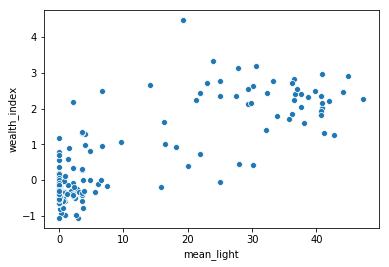

In [74]:
df_test = pd.read_csv('./data/rwanda.csv')
sns.scatterplot(x='mean_light', y='wealth_index', data=df_test)

## 5) Download daytime images

In [ ]:
image_folder = './data/daytime_images/rwanda/'